# CS492: 전산학특강<스마트에너지를 위한 인공지능> 
## Deep Learning Practice 
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

## Day 8 - Introduction to Advanced models
### 8-1. Neural machine translation with attention

#### Sequence to sequnce model
In this practice, we will implement a neural machine translation with attention. In general, the neural machine translation based on deep learning uses a *sequence-to-sequence (seq2seq)*.

This is made possible by the simple but powerful idea of the [sequence to sequence network](http://arxiv.org/abs/1409.3215), in which two recurrent neural networks work together to transform one sequence to another. An encoder network condenses an input sequence into a single vector, and a decoder network unfolds that vector into a new sequence.

The sequence to sequence (seq2seq) network is a model consisting of two separate RNNs called the **encoder** and **decoder**. The encoder reads an input sequence one item at a time, and outputs a vector at each step. The final output of the encoder is kept as the **context** vector. The decoder uses this context vector to produce a sequence of outputs one step at a time.

![Sequence to sequence](images/seq2seq.png)

#### Seq2seq model with attention

The fixed-length vector in the seq2seq model carries the burden of encoding the the entire "meaning" of the input sequence, no matter how long that may be. With all the variance in language, this is a very hard problem. Imagine two nearly identical sentences, twenty words long, with only one word different. Both the encoders and decoders must be nuanced enough to represent that change as a very slightly different point in space.

<img src=https://devblogs.nvidia.com/wp-content/uploads/2015/07/Figure6_sample_translations1.png width="700">


The **_attention mechanism_** introduced by [Bahdanau et al.](https://arxiv.org/abs/1409.0473) addresses this by giving the decoder a way to "pay attention" to parts of the input, rather than relying on a single vector. For every step the decoder can select a different part of the input sentence to consider.

![Sequence to sequence with attention](images/seq2seq-attention.png)

A**ttention is calculated with another fully connected feed-forward layer in the decoder.** This layer will use the current input and hidden state to create a new vector, which is the same size as the input sequence (in practice, a fixed maximum length). This vector is processed through softmax to create *attention weights*, which are multiplied by the encoders' outputs to create a new context vector, which is then used to predict the next output.

![Calculating context vector](images/context-vector.png)


For example, there is context vector $c_i$ generated by encoder, and at each timestep a hidden state of decoder can be computed as follows: <br>
#### $h_t = f(h_{t-1}, y_{t-1}, c_t)$
#### $p(y_t|y_1, \cdot\cdot\cdot, y_{t-1}, x) = g(y_{t-1}, h_t, c_t)$

In this case, the context vector contains entire meaning about input sentence. On the other hands, if adding the attention layer in the decoder, the context vector will be computed with attention weights like this: <br>
### $\alpha_{ts} = \frac{exp(score(h_t, h'_s))}{\sum_{s'=1}^s exp(score(h_t, h'_s))}$
#### $c_i = \sum_{s} \alpha_{ts}h'_s$

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

### Load and preprocess the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

`What was it that mary bought yesterday? \t'¿ Que es lo que compro ayer mary ?`

There are a variety of languages available, but we'll use the English-Spanish dataset.  For convenience, we've hosted a copy of this dataset in the lecture file. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a `<START>` and `<END>` token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → index and index → word).
4. Pad each sentence to a maximum length.

In [3]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

#### Preprocess the dataset

First, let's prepare *preprocess* functions to clean the sentences by removing special characters.

In [4]:
# re: python packager for regular expression
import re, unicodedata

def unicode_to_ascii(sentence):
    return ''.join(
        character for character in unicodedata.normalize('NFD', sentence) 
        if unicodedata.category(character) != 'Mn'
    )

def preprocess_sentence(sentence):
    sentence = unicode_to_ascii(sentence.lower().strip())
    
    # re.sub(pattern, repl, string): string에서 pattern과 매치하는 텍스트를 repl로 치환
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

In [5]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


#### Load the dataset

Then, we will load the dataset into the memory while applying `preprocess_sentence()`

In [6]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [7]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


#### Build the subword tokenizer

Now, we will build the subword tokenizer to tokenize the given texts as several subwords and to transform the subword tokens into integer vectors.

In [8]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,       
                                                           padding='post')

    return tensor, lang_tokenizer

In [10]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    inp_lang, targ_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

#### Limit the size of the dataset to experiment faster (optional)
Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [11]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [12]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [13]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [14]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
6 ----> you
24 ----> are
520 ----> children
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
158 ----> ustedes
43 ----> son
376 ----> ninos
3 ----> .
2 ----> <end>


#### Create a tf.data dataset

In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 11]), TensorShape([64, 16]))

#### Define seq2seq with attention model

Now, it is time to build the encoder and decoder models. Because these models are not provided by TensorFlow and Keras by default, we need to define our `tf.keras.Model` by manual using the class inheritance.

`Encoder` model takes an input vector and produces a context vector which summarizes all the input vector. To do that, we need the following layers:

- `tf.keras.layers.Embedding`
- `tf.keras.layers.GRU`

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units, batch_size):
        super().__init__()
        
        self.batch_size = batch_size
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, units)
        self.gru = tf.keras.layers.GRU(
            self.units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform',
        )
        
    def call(self, encoder_input, encoder_state):
        # encoder_input = (batch_size, length)
        
        # encoder_input = (batch_size, length, embedding_dim)
        encoder_input = self.embedding(encoder_input)
        
        # enocder_outputs = (batch_size, length, units)
        # encoder_state = (batch_size, units)
        enocder_outputs, encoder_state = self.gru(encoder_input, initial_state=encoder_state)
        
        return enocder_outputs, encoder_state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.units))

In [18]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 11, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


Here, we'll implement an encoder-decoder model with attention mechanism. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence.

<img src=https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg>


The input is put through an encoder model which gives us the encoder output of shape `(batch_size, length, units)` and the encoder hidden state of shape `(batch_size, units)`. 

Here are the equations that are implemented:
<img src=https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg>
<img src=https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg>

We will use [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) in this practice. 



In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        

    def call(self, query, values):
        # query = (batch_size, units)
        # values = (batch_size, length, units) // or key
        
        # query_with_time_axis = (batch_size, 1, units)
        query_with_time_axis = tf.expand_dims(query, 1)
        
        
        score = self.V(
            tf.nn.tanh(
                self.W1(values) # (batch_size, length, units) -> (batch_size, length, attention_units)
                + self.W2(query_with_time_axis) # (batch_size, 1, units) -> (batch_size, 1, attention_units)
            ) # (batch_size, length, attention_units)
        ) # (batch_size, length, 1)
        

        # attention_weights = (batch_size, length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector = (batch_size, length, units)
        context_vector = attention_weights * values
        # context_vector = (batch_size, units)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [20]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 11, 1)


Now, `Decoder` model takes the outputs from the `Encoder`, dynamically calculates a context vector at time step $t$ using attention mechanism, and predicts a next word given the previous word inputs.

To do that, we need the following layers:
- `tf.keras.layers.Embedding`
- `tf.keras.layers.GRU`
- `tf.keras.layers.Dense`

In [21]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units, batch_size):
        super().__init__()
        
        self.batch_size = batch_size
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)
        
    def call(self, decoder_input, decoder_state, enocder_outputs):
        # decoder_input = (batch_size, 1)
        # decoder_state = (batch_size, units)
        # enocder_outputs = (batch_size, length, units)
        
        # context_vector = (batch_size, units)
        # attention_weights = (batch_size, length, 1)
        context_vector, attention_weights = self.attention(decoder_state, enocder_outputs)
        
        # decoder_input = (batch_size, 1, embedding_dim)
        decoder_input = self.embedding(decoder_input)
        # decoder_input = (batch_size, 1, units + embedding_dim)
        decoder_input = tf.concat([
            tf.expand_dims(context_vector, 1),
            decoder_input,
        ], axis=-1)
        
        # decoder_output = (batch_size, 1, units)
        # decoder_state = (batch_size, 1, units)
        decoder_output, decoder_state = self.gru(decoder_input)
        # decoder_output = (batch_size, units)
        decoder_output = tf.reshape(decoder_output, (-1, decoder_output.shape[2]))
        # decoder_output = (batch_size, vocab_size)
        decoder_output = self.fc(decoder_output)
        
        return decoder_output, decoder_state, attention_weights

In [22]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 9414)


Once both the encoder and decoder are defined, we can initiate them like normal Python classes.

#### Define the loss and optimizer

Let's define the loss functions and the optimizers for the seq2seq model. Here, because the input dataset consists sentences of various lengths, we need to consider that point when caclculating the loss. Otherwise, the loss will be too grater than expected. To do that, we create a `mask` matrix and discard unnecessary values.

In [23]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

#### Train seq2seq model using `tf.GradientTape`

1. Pass the _input_ through the _encoder_ which return _encoder output_ and the _encoder hidden state_.
1. The encoder output, encoder hidden state and the decoder input is passed to the decoder.
1. The decoder returns the _predictions_ and the _decoder hidden state_.
1. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
1. Use _teacher forcing_ to decide the next input to the decoder.
1. _Teacher forcing_ is the technique where the _target_ word is passed as the _next input_ to the decoder.
1. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [25]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        
        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            loss += loss_function(targ[:, t], predictions)
            
        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)
        
    batch_loss = (loss / int(targ.shape[1]))
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, variables)
    
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [69]:
EPOCHS = 100

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Loss 0.2499
Time taken for 1 epoch 64.7037205696106 sec

Epoch 2 Loss 0.2287
Time taken for 1 epoch 65.29573512077332 sec

Epoch 3 Loss 0.2160
Time taken for 1 epoch 64.7155933380127 sec

Epoch 4 Loss 0.2010
Time taken for 1 epoch 65.30595183372498 sec

Epoch 5 Loss 0.1892
Time taken for 1 epoch 64.73133873939514 sec

Epoch 6 Loss 0.1784
Time taken for 1 epoch 65.41905355453491 sec

Epoch 7 Loss 0.1705
Time taken for 1 epoch 64.4306206703186 sec

Epoch 8 Loss 0.1740
Time taken for 1 epoch 65.341304063797 sec

Epoch 9 Loss 0.1650
Time taken for 1 epoch 64.6692807674408 sec

Epoch 10 Loss 0.1587
Time taken for 1 epoch 65.44934391975403 sec

Epoch 11 Loss 0.1571
Time taken for 1 epoch 64.66161751747131 sec

Epoch 12 Loss 0.1493
Time taken for 1 epoch 65.48871064186096 sec

Epoch 13 Loss 0.1511
Time taken for 1 epoch 64.60211610794067 sec

Epoch 14 Loss 0.1466
Time taken for 1 epoch 65.64683270454407 sec

Epoch 15 Loss 0.1461
Time taken for 1 epoch 64.61097836494446 sec

Epoch 16 L

#### Translate
- The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
- Stop predicting when the model predicts the end token.
- And store the attention weights for every time step.

In [26]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [27]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [28]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

#### Restore the latest checkpoint and test
For Colab:

In [ ]:
from google.colab import drive

drive.mount('/gdrive')

In [ ]:
import os

gdrive_root = '/gdrive/My Drive'
print('In gdrive :', os.listdir(gdrive_root))

notebook_dir = os.path.join(gdrive_root, 'Colab Notebooks')
print('In Colab Notebooks :', os.listdir(notebook_dir))

In [ ]:
checkpoint_dir = os.path.join (notebook_dir, 'cs492_day8_checkpoints')

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [29]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> what is your name ? <end>
Predicted translation: ¿ cual es tu nombre ? <end> 


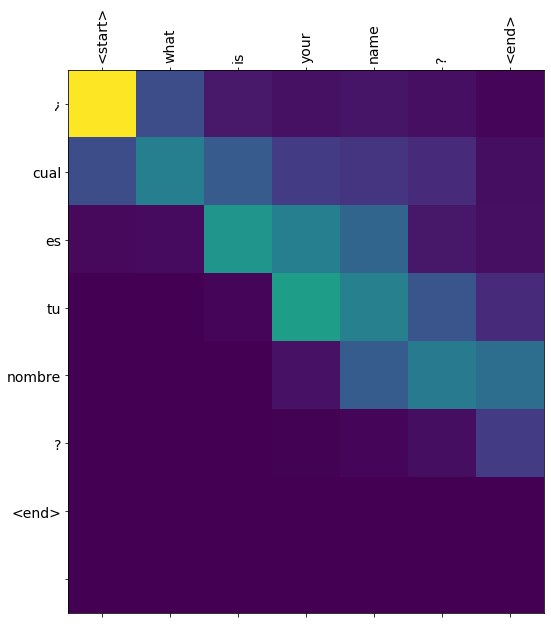

In [74]:
translate('What is your name?')

Input: <start> they kept me waiting for minutes . <end>
Predicted translation: me me fuera mas . . <end> 


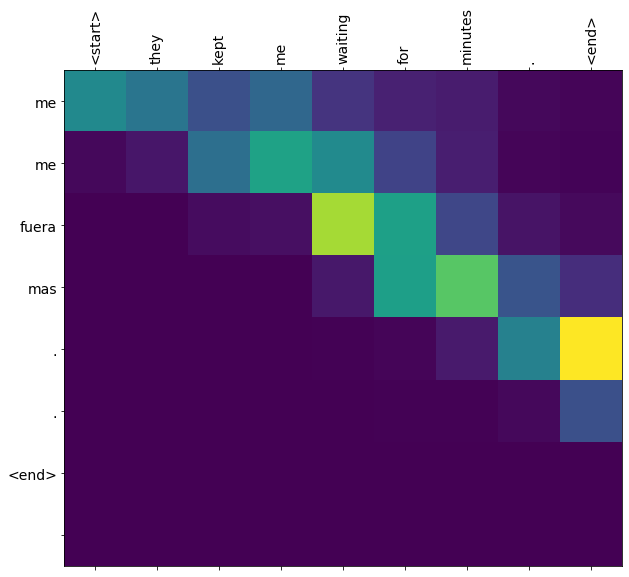

In [75]:
translate('They kept me waiting for minutes.')